In [105]:
import csv
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

In [106]:
np.random.seed(42)
# print(np.random.rand())
for i in range(5):
    print(np.random.rand())

0.3745401188473625
0.9507143064099162
0.7319939418114051
0.5986584841970366
0.15601864044243652


In [107]:
# 評価する手法・モデル・データセットごとにこのファイルを複製する
approach_list = [
                #  'FL',
                 'SFL',
                #  'PSL'
                #  'Proto_SFL',
                #  'Moco_SFL',
                #  'MOON_SFL', 
                 'KD_SFL',
                 'MKD_SFL'
                #  'Tim_SFL'
                ]

dir_name = {
            'FL': 'FL',
            'SFL': 'SL_SFL',
            'PSL': 'SL',
            'Proto_SFL': 'SL_SFL_Proto',
            'Moco_SFL': 'SL_SFL_Moco',
            'MOON_SFL': 'SL_SFL_Con',
            'KD_SFL': 'SL_SFL_KD',
            'MKD_SFL': 'SL_SFL_MKD',
            'Tim_SFL': 'SL_SFL_TiM'
            }

r_path = './../results/'
m_path = '/mobilenet_v2_cifar10/'
path_dict = {}

for i in range(len(approach_list)):
    path_dict[approach_list[i]] = r_path + dir_name[approach_list[i]] + m_path

date_dir_dict = {
                # 'FL': ['2024-08-26/'],
                'SFL':['2024-08-26/'],
                # 'PSL': ['2024-08-26/']
                # 'Proto_SFL': ['2024-08-28/'],
                # 'Moco_SFL': ['2024-09-02/', '2024-09-03/', '2024-09-06/'],
                # 'MOON_SFL': ['2024-08-26/'],
                'KD_SFL': ['2024-09-09/', '2024-09-10/'],
                'MKD_SFL':['2024-08-28/']
                # 'Tim_SFL': ['2024-08-31/', '2024-09-01/', '2024-09-04/', '2024-09-08/'],
                }

data_dir_list = ['accuracy', 'loss']
batch_type_list = ['B128', 'B64']
data_type_list = ['IID', 'N-IID-Diri-01', 'N-IID-Diri-005', 'N-IID-ClassSep',]
epoch_type_list = ['R50_E5', 'R25_E10']

In [108]:
def make_templete():
    batch_dict = {}
    epoch_dict = {}
    data_type_dict = {}

    for data_type in data_type_list:
        data_type_dict[data_type] = None
    for epoch_type in epoch_type_list:
        epoch_dict[epoch_type] = copy.deepcopy(data_type_dict)
    for batch_type in batch_type_list:
        batch_dict[batch_type] = copy.deepcopy(epoch_dict)
    
    return batch_dict

In [109]:
def input_to_dict(app_dict, app_name, date_dir_list): # valueを引数にする
    for batch_type, epoch_dict in app_dict.items():
        for epoch_type, data_type_dict in epoch_dict.items():
            for data_type, _ in data_type_dict.items():

                data_dict = {'epoch': {'accuracy': [], 'loss': []}, 'accuracy': [], 'loss': []}

                for date_dir in date_dir_list:
                    for data_name in data_dir_list:

                        file_path = path_dict[app_name] + date_dir + data_name + '/' + data_type + '_' + batch_type + '_' + epoch_type + '_' + data_name + '.csv'

                        if os.path.isfile(file_path):
                            with open(file_path) as f:
                                csv_reader = csv.reader(f, delimiter=',')
                                for i, row in enumerate(csv_reader):
                                    if i == 0:
                                        continue
                                    else:
                                        data_dict['epoch'][data_name].append(float(row[0]))
                                        data_dict[data_name].append(float(row[1]))
                            if data_name == 'accuracy':
                                if len(data_dict['epoch'][data_name]) == 25:
                                    data_dict['epoch'][data_name] = [ x * 10 for x in data_dict['epoch'][data_name]]
                                elif len(data_dict['epoch'][data_name]) == 50:
                                    data_dict['epoch'][data_name] = [ x * 5 for x in data_dict['epoch'][data_name]]
                            elif data_name == 'loss':
                                if len(data_dict[data_name]) == 500:
                                    data_dict[data_name] = data_dict[data_name][0::2]
                                elif len(data_dict[data_name]) == 1000:
                                    data_dict[data_name] = data_dict[data_name][0::4]
                                data_dict['epoch'][data_name] = np.arange(1, len(data_dict[data_name])+1)
                    app_dict[batch_type][epoch_type][data_type] = data_dict

    return app_dict

In [110]:
app_dict = {}
for i in range(len(approach_list)):
    app_dict[approach_list[i]] = make_templete()

for idx in range(len(approach_list)):
    key = list(date_dir_dict.keys())[idx]
    value = date_dir_dict[key]
    app_dict[key] = input_to_dict(app_dict[key], key, value)

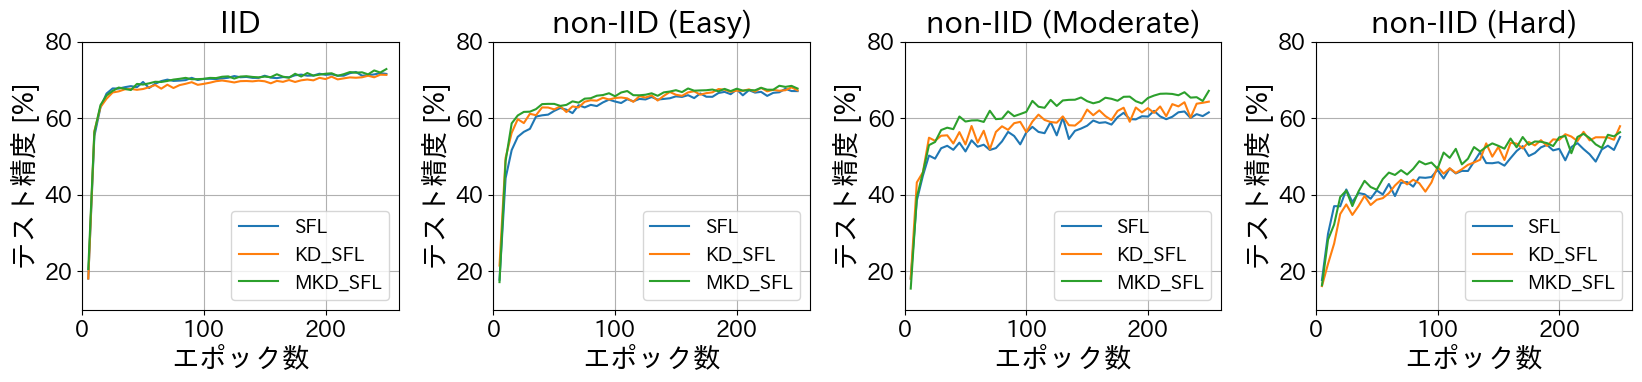

In [111]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 13))
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
fig.subplots_adjust(hspace=0.3, wspace=0.3, top=0.78)

for app_name, dict in app_dict.items():
    for j, data_type in enumerate(data_type_list):
        ax = axes[j]
        # if j == 0 or j == 1:
        #     ax = axes[0, j]
        # elif j == 2 or j == 3:
        #     ax = axes[1, j-2]
        for i, epoch_type in enumerate(epoch_type_list):
            if epoch_type == 'R25_E10':
                continue
            for batch_type in batch_type_list:
                if batch_type == 'B64':
                    continue
                if dict[batch_type][epoch_type][data_type]['accuracy'] is not None:
                    epoch = dict[batch_type][epoch_type][data_type]['epoch']['accuracy']
                    accuracy = dict[batch_type][epoch_type][data_type]['accuracy']
                    ax.plot(epoch, accuracy, label=app_name)
        if data_type == 'IID':
            title = 'IID'
        elif data_type == 'N-IID-Diri-01':
            title = 'non-IID (Easy)'
        elif data_type == 'N-IID-Diri-005':
            title = 'non-IID (Moderate)'
        elif data_type == 'N-IID-ClassSep':
            title = 'non-IID (Hard)'

        # if data_type == 'IID':
        #     title = 'IID'
        # elif data_type == 'N-IID-Diri-01':
        #     title = 'Non-IID (Easy)'
        # elif data_type == 'N-IID-Diri-005':
        #     title = 'Non-IID (Moderate)'
        # elif data_type == 'N-IID-ClassSep':
        #     title = 'Non-IID (Hard)'

        # ax.set_title(epoch_type + '_' + data_type)
        ax.set_title(title, fontsize=22)
        ax.set_xlabel('エポック数', fontsize=20) # 16
        ax.set_ylabel('テスト精度 [%]', fontsize=20) # 16
        ax.set_ylim((10, 80))
        ax.set_xlim((0, 260))
        ax.tick_params(axis='x', labelsize=16) # 14
        ax.tick_params(axis='y', labelsize=16) # 14
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=14) #12
# fig.suptitle('Epoch Type: R50_E5', fontsize=24)
plt.savefig('./../../../Testing/compare_approach_R50.pdf', format='pdf', bbox_inches="tight")
plt.show()

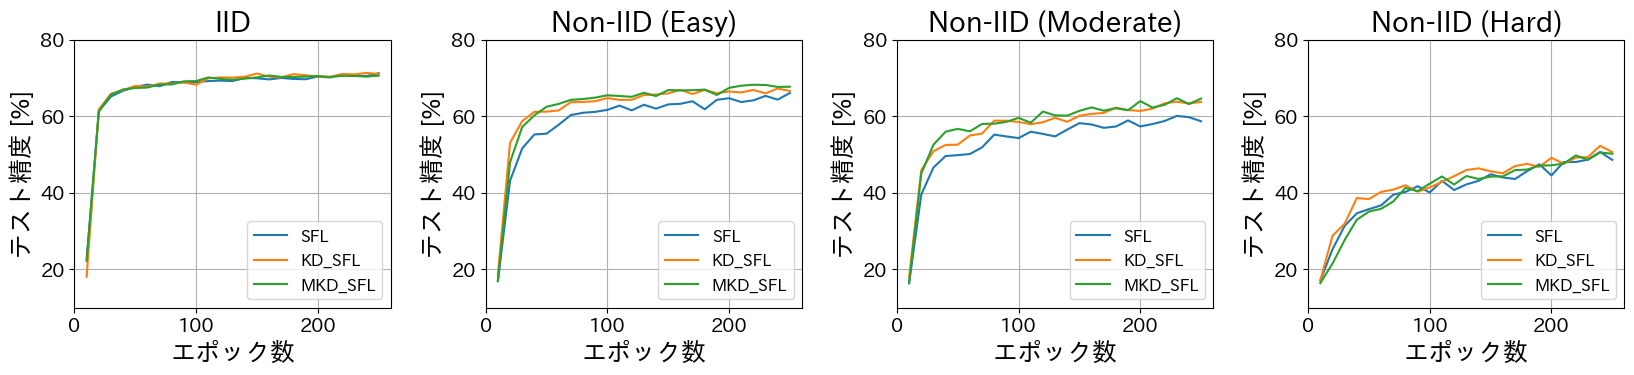

In [112]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
fig.subplots_adjust(hspace=0.3, wspace=0.3, top=0.78)

for app_name, dict in app_dict.items():
    for j, data_type in enumerate(data_type_list):
        ax = axes[j]
        # if j == 0 or j == 1:
        #     ax = axes[0, j]
        # elif j == 2 or j == 3:
        #     ax = axes[1, j-2]
        for i, epoch_type in enumerate(epoch_type_list):
            if epoch_type == 'R50_E5':
                continue
            for batch_type in batch_type_list:
                if batch_type == 'B64':
                    continue
                if dict[batch_type][epoch_type][data_type]['accuracy'] is not None:
                    epoch = dict[batch_type][epoch_type][data_type]['epoch']['accuracy']
                    accuracy = dict[batch_type][epoch_type][data_type]['accuracy']
                    ax.plot(epoch, accuracy, label=app_name)
        if data_type == 'IID':
            title = 'IID'
        elif data_type == 'N-IID-Diri-01':
            title = 'Non-IID (Easy)'
        elif data_type == 'N-IID-Diri-005':
            title = 'Non-IID (Moderate)'
        elif data_type == 'N-IID-ClassSep':
            title = 'Non-IID (Hard)'
        # ax.set_title(epoch_type + '_' + data_type)
        ax.set_title(title, fontsize=20)
        ax.set_xlabel('エポック数', fontsize=18)
        ax.set_ylabel('テスト精度 [%]', fontsize=18)
        ax.set_ylim((10, 80))
        ax.set_xlim((0, 260))
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=12)
# fig.suptitle('Epoch Type: R25_E10', fontsize=24)
plt.savefig('./../../../Testing/compare_approach_R25.pdf', format='pdf', bbox_inches="tight")
plt.show()

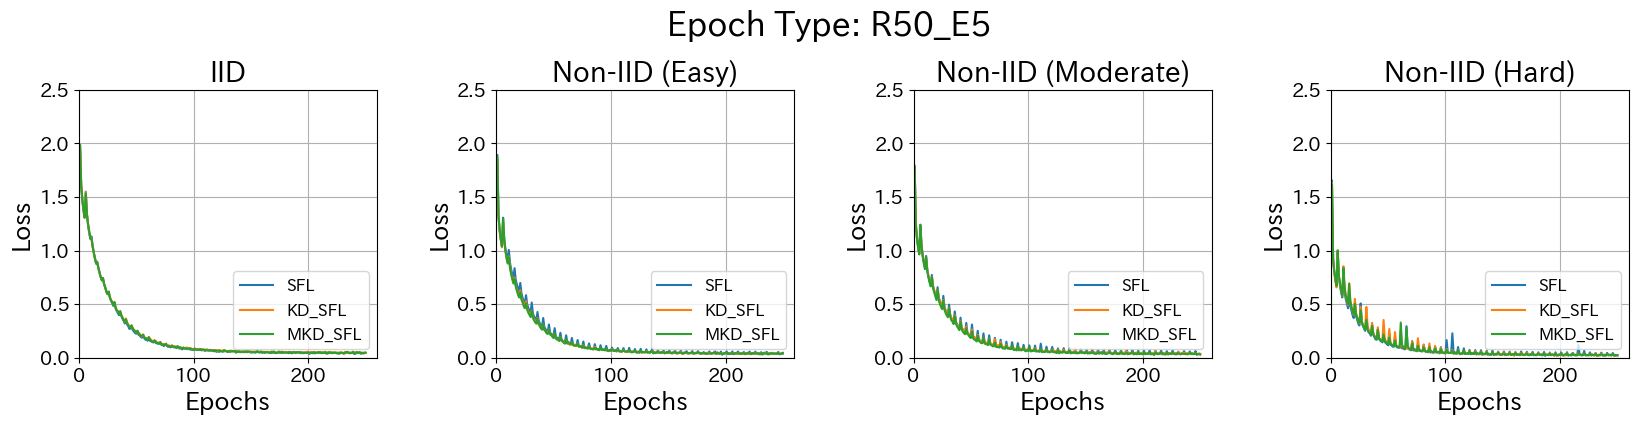

In [113]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.78)

for app_name, dict in app_dict.items():
    for j, data_type in enumerate(data_type_list):
        ax = axes[j]
        for i, epoch_type in enumerate(epoch_type_list):
            if epoch_type == 'R25_E10':
                continue
            for batch_type in batch_type_list:
                if batch_type == 'B64':
                    continue
                if dict[batch_type][epoch_type][data_type]['loss'] is not None:
                    epoch = dict[batch_type][epoch_type][data_type]['epoch']['loss']
                    loss = dict[batch_type][epoch_type][data_type]['loss']
                    ax.plot(epoch, loss, label=app_name)
        if data_type == 'IID':
            title = 'IID'
        elif data_type == 'N-IID-Diri-01':
            title = 'Non-IID (Easy)'
        elif data_type == 'N-IID-Diri-005':
            title = 'Non-IID (Moderate)'
        elif data_type == 'N-IID-ClassSep':
            title = 'Non-IID (Hard)'
        # ax.set_title(epoch_type + '_' + data_type)
        ax.set_title(title, fontsize=20)
        ax.set_xlabel('Epochs', fontsize=18)
        ax.set_ylabel('Loss', fontsize=18)
        ax.set_ylim((0, 2.5))
        ax.set_xlim((0, 260))
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=12)
fig.suptitle('Epoch Type: R50_E5', fontsize=24)
# plt.savefig('./../../../Testing/compare_approach_R25.pdf', format='pdf', bbox_inches="tight")
plt.show()

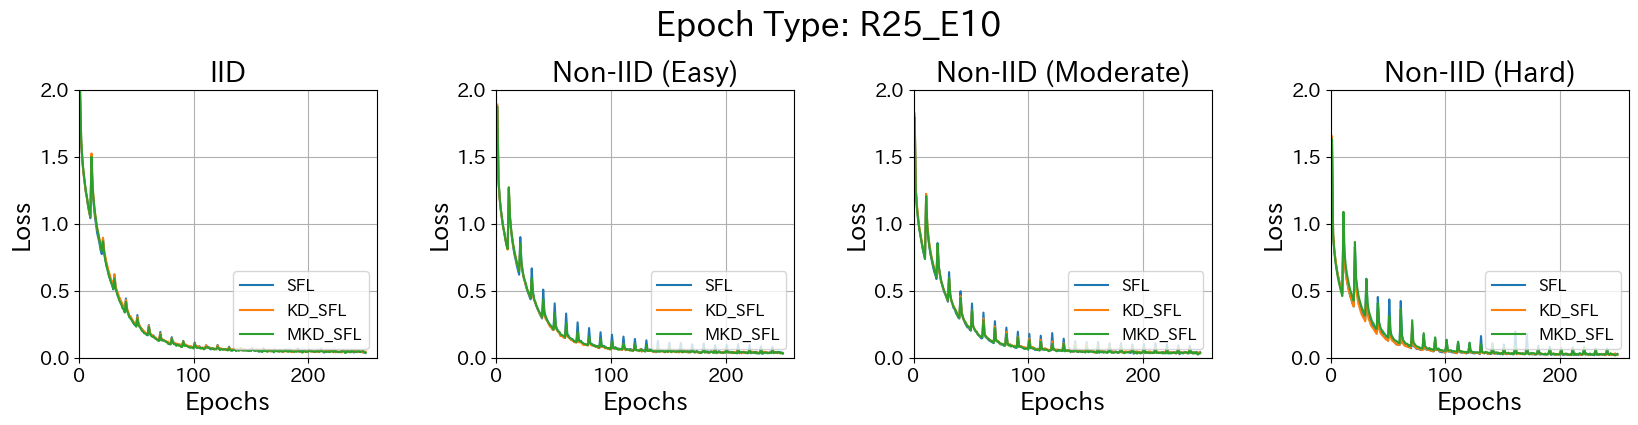

In [114]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.78)

for app_name, dict in app_dict.items():
    for j, data_type in enumerate(data_type_list):
        ax = axes[j]
        for i, epoch_type in enumerate(epoch_type_list):
            if epoch_type == 'R50_E5':
                continue
            for batch_type in batch_type_list:
                if batch_type == 'B64':
                    continue
                if dict[batch_type][epoch_type][data_type]['loss'] is not None:
                    epoch = dict[batch_type][epoch_type][data_type]['epoch']['loss']
                    loss = dict[batch_type][epoch_type][data_type]['loss']
                    ax.plot(epoch, loss, label=app_name)
        if data_type == 'IID':
            title = 'IID'
        elif data_type == 'N-IID-Diri-01':
            title = 'Non-IID (Easy)'
        elif data_type == 'N-IID-Diri-005':
            title = 'Non-IID (Moderate)'
        elif data_type == 'N-IID-ClassSep':
            title = 'Non-IID (Hard)'
        # ax.set_title(epoch_type + '_' + data_type)
        ax.set_title(title, fontsize=20)
        ax.set_xlabel('Epochs', fontsize=18)
        ax.set_ylabel('Loss', fontsize=18)
        ax.set_ylim((0, 2))
        ax.set_xlim((0, 260))
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=12)
fig.suptitle('Epoch Type: R25_E10', fontsize=24)
# plt.savefig('./../../../Testing/compare_approach_R25.pdf', format='pdf', bbox_inches="tight")
plt.show()

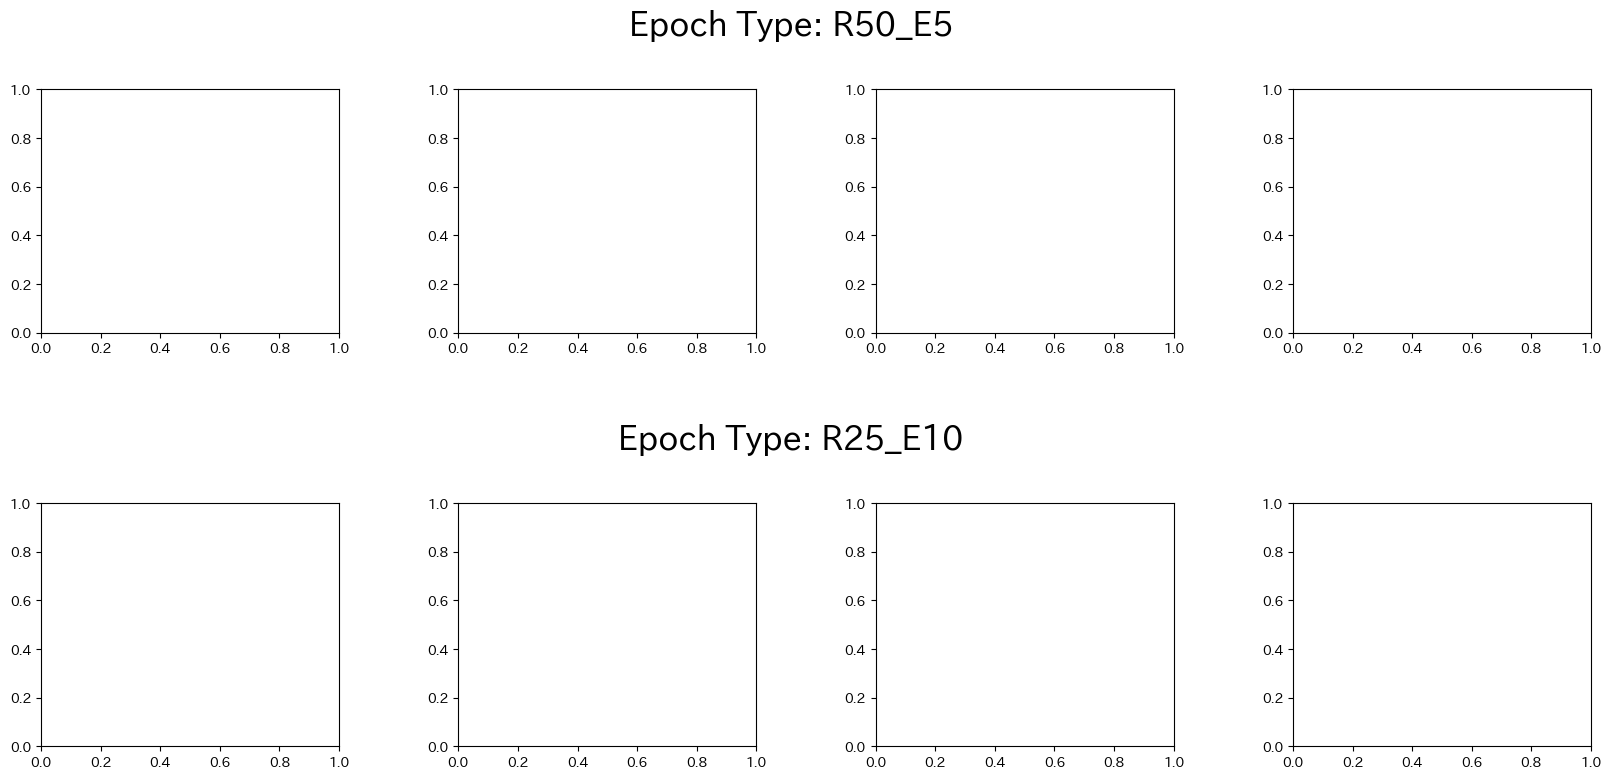

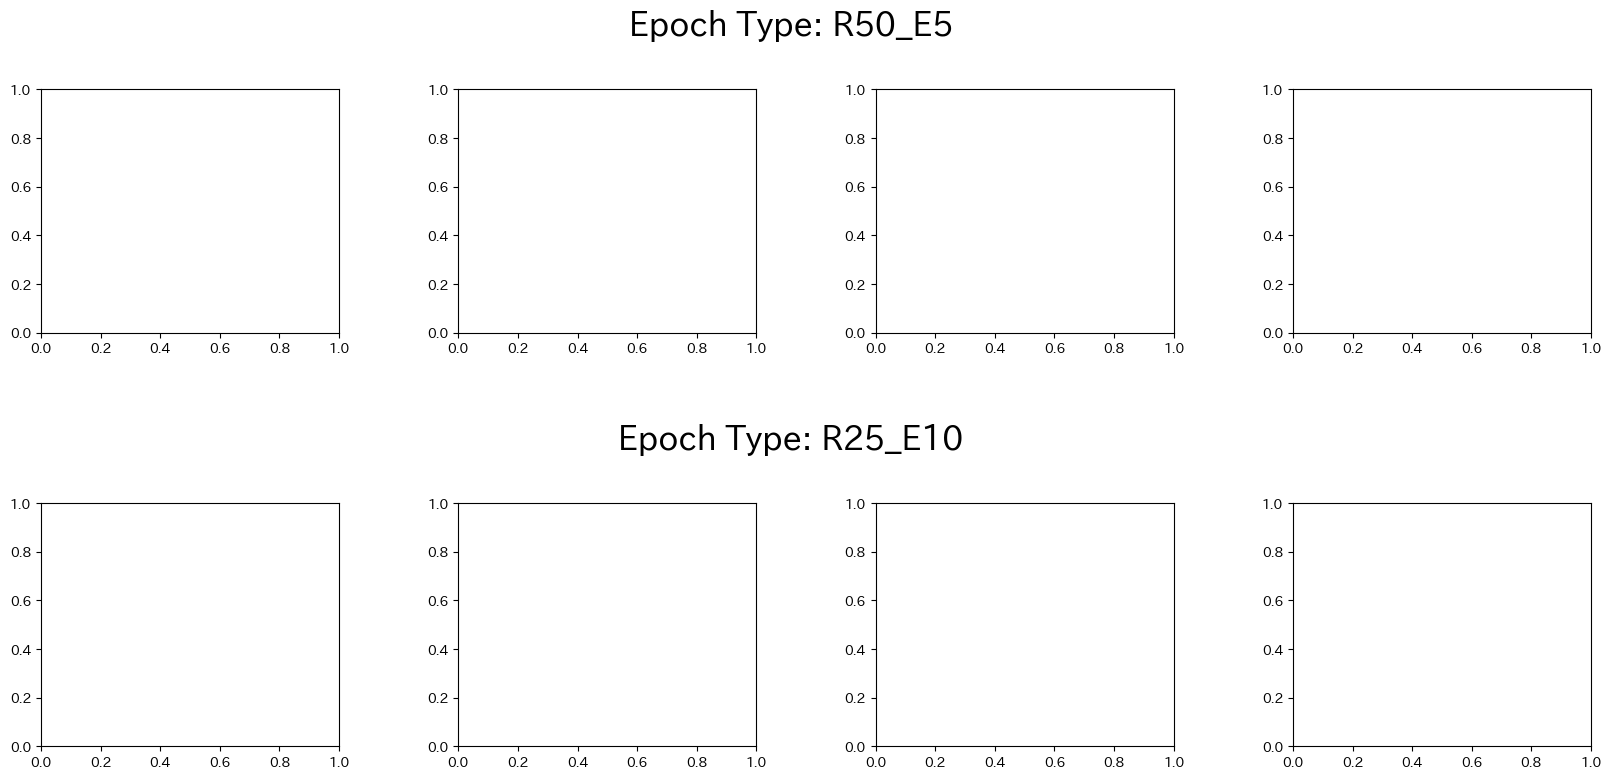

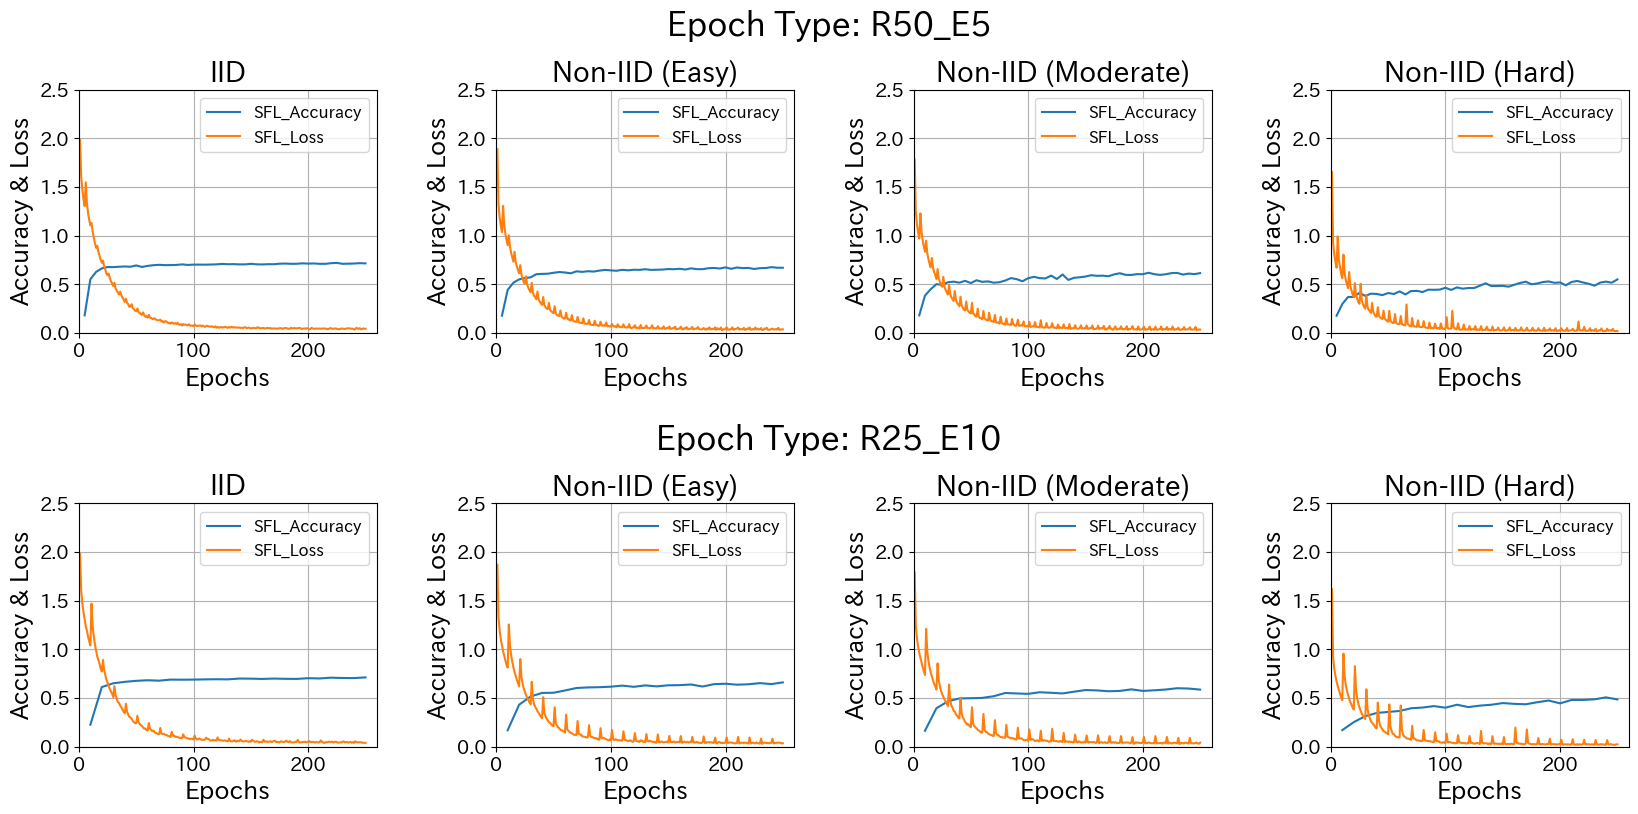

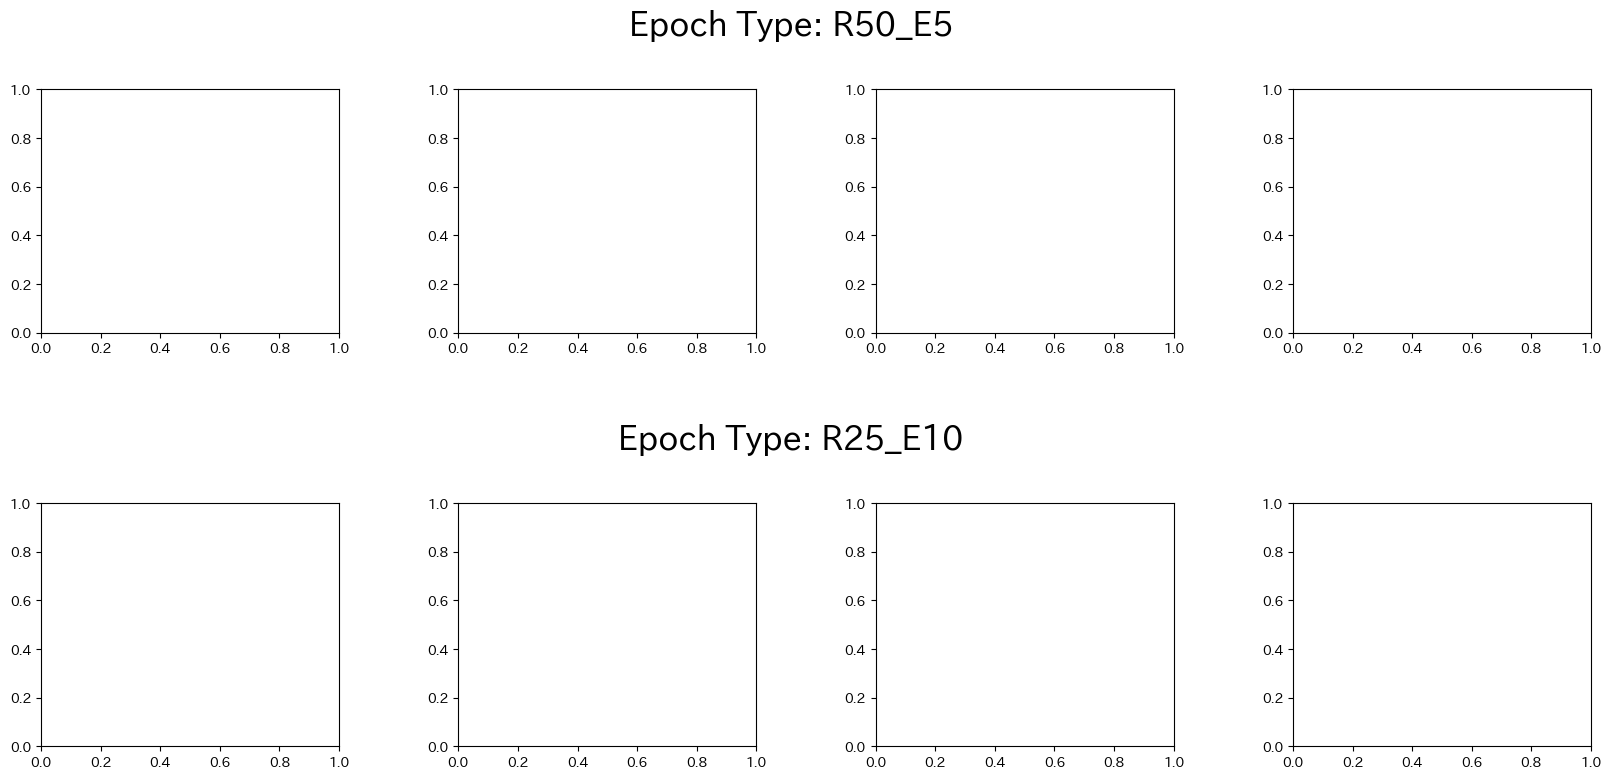

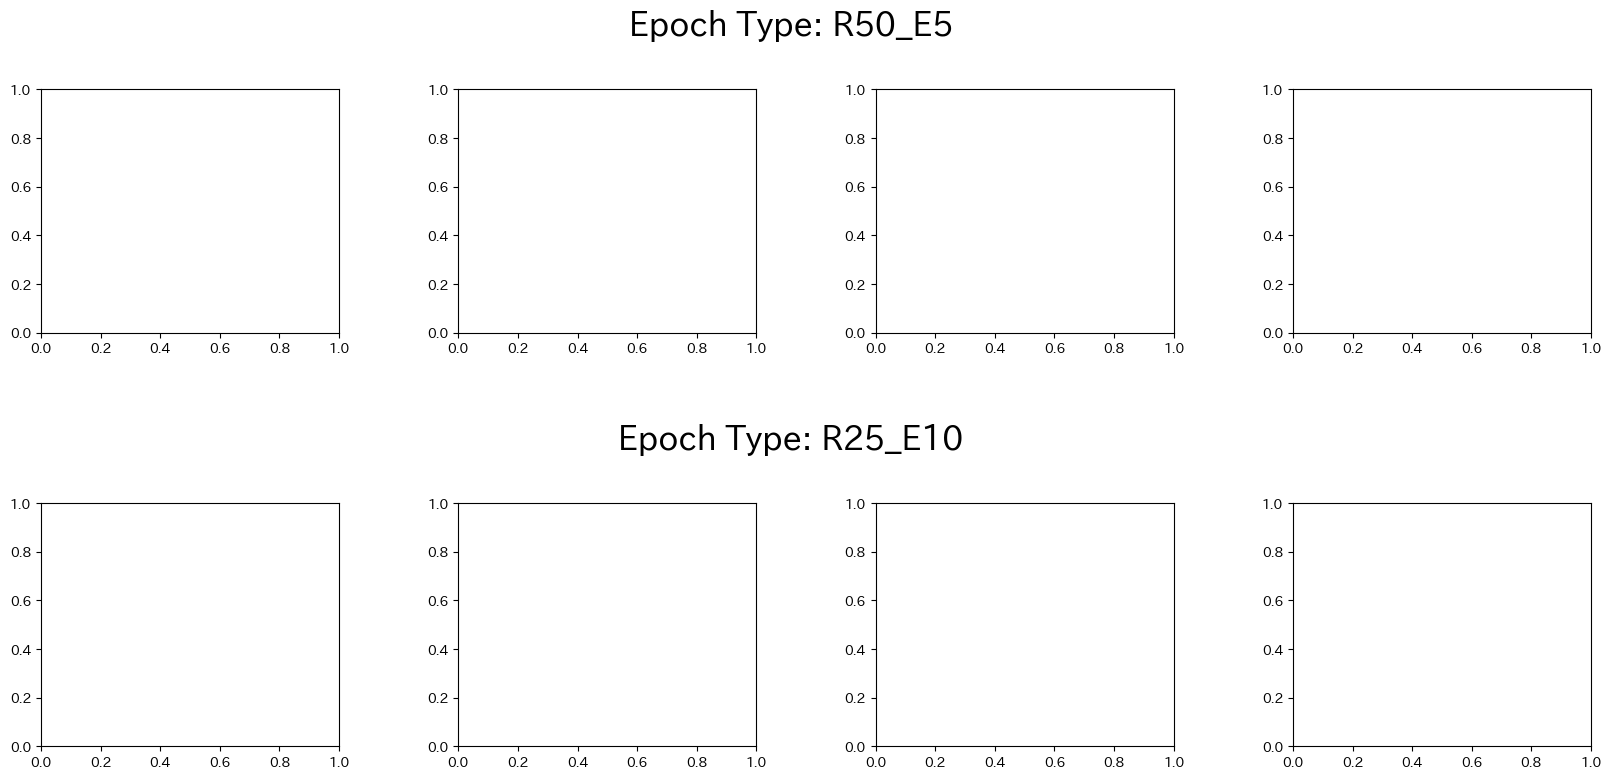

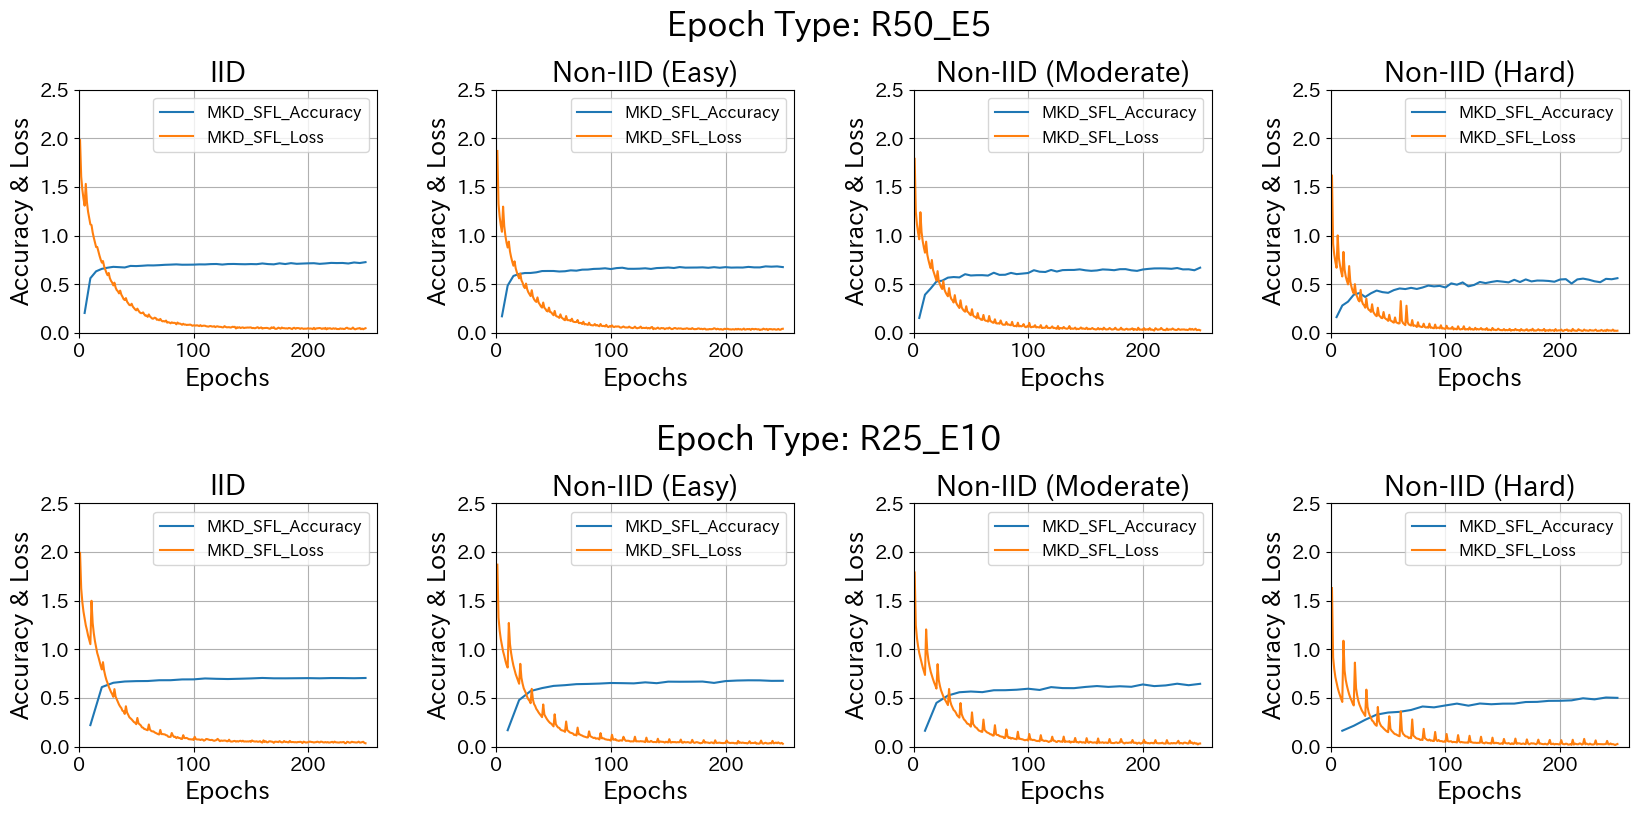

In [115]:
approach_name = ['FL', 'SL', 'SFL', 'Proto_SFL', 'MOON_SFL', 'MKD_SFL']

for idx in range(len(approach_name)):
    fig, axes = plt.subplots(2, 4, figsize=(20, 9))
    fig.subplots_adjust(hspace=0.7, wspace=0.4, top=0.84)

    row_titles = ['Epoch Type: R50_E5', 'Epoch Type: R25_E10']

    for row in range(2):
        fig.text(0.5, 0.9 - row*0.46, row_titles[row], ha='center', fontsize=24)

    for app_name, dict in app_dict.items():
        if app_name == approach_name[idx]:
            for j, data_type in enumerate(data_type_list):
                # ax = axes[j]
                for i, epoch_type in enumerate(epoch_type_list):
                    ax = axes[i, j]
                    for batch_type in batch_type_list:
                        if batch_type == 'B64':
                            continue
                        if dict[batch_type][epoch_type][data_type]['accuracy'] is not None:
                            epoch = dict[batch_type][epoch_type][data_type]['epoch']['accuracy']
                            accuracy = dict[batch_type][epoch_type][data_type]['accuracy']
                            accuracy = [ acc / 100 for acc in accuracy]
                            ax.plot(epoch, accuracy, label=app_name + '_Accuracy')
                        if dict[batch_type][epoch_type][data_type]['loss'] is not None:
                            epoch = dict[batch_type][epoch_type][data_type]['epoch']['loss']
                            loss = dict[batch_type][epoch_type][data_type]['loss']
                            ax.plot(epoch, loss, label=app_name + '_Loss')
                    if data_type == 'IID':
                        title = 'IID'
                    elif data_type == 'N-IID-Diri-01':
                        title = 'Non-IID (Easy)'
                    elif data_type == 'N-IID-Diri-005':
                        title = 'Non-IID (Moderate)'
                    elif data_type == 'N-IID-ClassSep':
                        title = 'Non-IID (Hard)'
                    # ax.set_title(epoch_type + '_' + data_type)
                    ax.set_title(title, fontsize=20)
                    ax.set_xlabel('Epochs', fontsize=18)
                    ax.set_ylabel('Accuracy & Loss', fontsize=18)
                    ax.set_ylim((0, 2.5))
                    ax.set_xlim((0, 260))
                    ax.tick_params(axis='x', labelsize=14)
                    ax.tick_params(axis='y', labelsize=14)
                    ax.grid(True)
                    ax.legend(loc='upper right', fontsize=12)
    # fig.suptitle(approach_name[idx], fontsize=24)
    # plt.savefig('./../../../Testing/compare_approach_R50.pdf', format='pdf', bbox_inches="tight")
    plt.show()